<a href="https://www.kaggle.com/code/oscarm524/fraud-detection-eda-fe-modeling?scriptVersionId=143010826" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Predicting fraud at self-checkout in retail</h1>

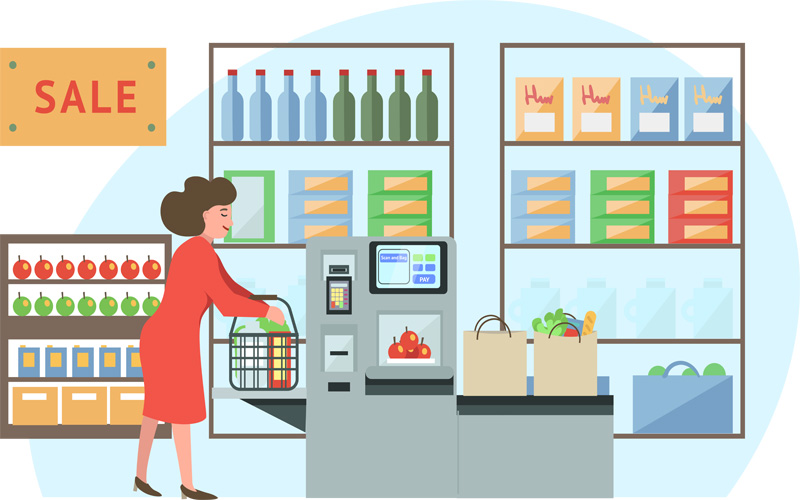

The number of self-checkout stations is on the rise. This includes stationary self-checkouts, where customers take their shopping cart to a scan station and pay for their products. Secondly, there are semi-stationary self-checkouts, where customers scan their products directly and only pay at a counter. The customers either use their own smartphone for scanning or the store provides mobile scanners. You will probably have encountered this already.

This automated process helps avoid long lines and speeds up the paying process for individual customers. But how can retailers prevent the trust they have placed in customers from being abused? How can they decide which purchases to check in an effort to expose fraudsters without annoying innocent customers? 

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Loading Libraries](#Loading-Libraries)

[2. Reading Data](#Reading-Data-Files)

[3. Data Description](#Data-Description)

[4. Data Exploration](#Data-Exploration)

[5. Feature Engineering](#Feature-Engineering)

[6. Feature Selection](#Feature-Selection)

[7. Feature Importance](#Feature-Importance)

[8. Evaluation Metric](#Evaluation-Metric)

[9. XGBoost Modeling](#XGBoost-Modeling)

[10. LightGBM Modeling](#LightGBM-Modeling)

[11. Next Steps](#Next-Steps)

For more information about the dataset click [here](https://www.kaggle.com/datasets/oscarm524/fraud-detection-in-grocery-shopping-transactions).

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>

In [ ]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1>

In [ ]:
train = pd.read_csv('/kaggle/input/fraud-detection-in-grocery-shopping-transactions/train.csv', sep = '|')
test = pd.read_csv('/kaggle/input/fraud-detection-in-grocery-shopping-transactions/test.csv', sep = '|')

print('The shape of train dataset is', train.shape)
print('The shape of test dataset is', test.shape)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

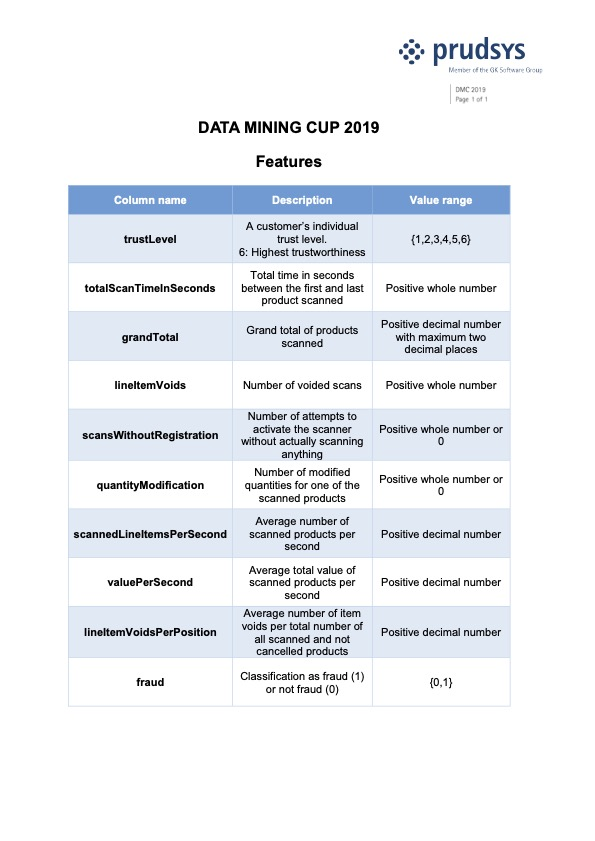

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

In [ ]:
train.head()

In [ ]:
train.describe()

In [ ]:
round(100*train['fraud'].value_counts() / train.shape[0], 2) 

In [ ]:
sns.countplot(x = 'fraud', hue = 'fraud', data = train);

> <div class="alert alert-block alert-info">
<b>Insight:</b> 5.5% of the transactions are labeled as fraudulent (imbalanced dataset)</div>

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))

sns.countplot(ax = axes[0, 0], x = 'trustLevel', hue = 'fraud', data = train)
sns.countplot(ax = axes[0, 1], x = 'lineItemVoids', hue = 'fraud', data = train)
sns.countplot(ax = axes[1, 0], x = 'scansWithoutRegistration', hue = 'fraud', data = train)
sns.countplot(ax = axes[1, 1], x = 'quantityModifications', hue = 'fraud', data = train)

plt.show();

> <div class="alert alert-block alert-info">
<b>Insight:</b> In the top left panel, notice that only customers with trustlevel 1 or 2 have fraud cases.</div>

In [ ]:
sns.pairplot(train[['totalScanTimeInSeconds', 'grandTotal', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'fraud']] , hue = 'fraud', height = 5);

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Feature Engineering</h1>

In [ ]:
## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X, Y)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True);

In [ ]:
## Feature 1 (from decision tree)
train['Interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012), 0, 1)
test['Interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012), 0, 1)

## Feature 2 (from decision tree)
train['Interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & (train['totalScanTimeInSeconds'] <= 895.0), 0, 1)
test['Interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & (test['totalScanTimeInSeconds'] <= 895.0), 0, 1)

## Feature 3 (from decision tree)
train['Interaction_3'] = np.where((train['trustLevel'] == 2) & (train['totalScanTimeInSeconds'] <= 1298.0), 0, 1)
test['Interaction_3'] = np.where((test['trustLevel'] == 2) & (test['totalScanTimeInSeconds'] <= 1298.0), 0, 1)

## Feature 4 - Low trustLevel (all frauds came from trustLevel = 1 or 2)
train['lowTrust'] = np.where(train['trustLevel'] <= 2, 1, 0)
test['lowTrust'] = np.where(test['trustLevel'] <= 2, 1, 0)

## Feature 5 - Made a quantity modification
train['madeModification'] = np.where(train['quantityModifications'] > 0, 1, 0)
test['madeModification'] = np.where(test['quantityModifications'] > 0, 1, 0)

## Feature 6 - Attempted a scan without registration
train['madeScansWithoutRegistration'] = np.where(train['scansWithoutRegistration'] > 0, 1, 0)
test['madeScansWithoutRegistration'] = np.where(test['scansWithoutRegistration'] > 0, 1, 0)

## Feature 7 - High or low totalScanTimeInSeconds (huge differnece in mean and median values for fraud/not fraud in this field)
train['lowTotalScanTime'] = np.where(train['totalScanTimeInSeconds'] < 1000, 1, 0)
test['lowTotalScanTime'] = np.where(test['totalScanTimeInSeconds'] < 1000, 1, 0)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Feature Importance</h1>

Because most of the time tree-based models agree with feature importance, I will use random forest to identify important features to predict fraud. 

In [ ]:
## Defining the input and target variables
X = train.drop(columns = ['trustLevel', 'fraud'])
Y = train['fraud']

## Defining a list to store results
results = []

## Repeating process 100 times
for i in range(0, 100):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Building the model
    rf_md = RandomForestClassifier(max_depth = 3, n_estimators = 500).fit(X_train, Y_train)
    
    ## Extracting feature importance scores
    results.append(rf_md.feature_importances_)
    
## Changing results list to a dataframe
results = pd.DataFrame(results, columns = X.columns)

## Computing averages and sorting variables by importance
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importance': results[0].values}).sort_values(by = 'Importance', ascending = False)

## Visualizing importances
fig = plt.figure(figsize = (10, 8))
sns.barplot(x = 'Importance', y = 'Feature', data = results, color = 'blue');

Adding interactions among top 3 features

In [ ]:
train['Heredity_Feature_1'] = train['lowTrust'] * train['scannedLineItemsPerSecond']
train['Heredity_Feature_2'] = train['lowTrust'] * train['lineItemVoidsPerPosition']
train['Heredity_Feature_3'] = train['scannedLineItemsPerSecond'] * train['lineItemVoidsPerPosition']

test['Heredity_Feature_1'] = test['lowTrust'] * test['scannedLineItemsPerSecond']
test['Heredity_Feature_2'] = test['lowTrust'] * test['lineItemVoidsPerPosition']
test['Heredity_Feature_3'] = test['scannedLineItemsPerSecond'] * test['lineItemVoidsPerPosition']

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Feature Selection</h1>

In [ ]:
## Defining the input and target variables
X = train.drop(columns = ['trustLevel', 'fraud'])
Y = train['fraud']

## Defining empty list to store results
xgb_support, lightgbm_support, cat_support = list(), list(), list()

## Repeating steps 50 times:
for i in tqdm(range(0, 50)):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Runing RFE (recursive feature elimination) with XGBoost as a base algorithm (with n_features_to_select = 5)
    xgb_rfe = RFE(estimator = XGBClassifier(), n_features_to_select = 5).fit(X_train, Y_train)
    
    ## Appending the features to be selected
    xgb_support.append(xgb_rfe.support_)
    
    ## Runing RFE (recursive feature elimination) with LightGBM as the base algorithm 
    ## (with n_features_to_select = 5)
    lightgbm_rfe = RFE(estimator = LGBMClassifier(), n_features_to_select = 5).fit(X_train, Y_train)
    
    ## Appending the features to be selected
    lightgbm_support.append(lightgbm_rfe.support_)
        

xgb_support = pd.DataFrame(xgb_support, columns = X.columns)
xgb_support = 100 * xgb_support.apply(np.sum, axis = 0) / xgb_support.shape[0]
xgb_support = xgb_support.sort_values(ascending = True)

lightgbm_support = pd.DataFrame(lightgbm_support, columns = X.columns)
lightgbm_support = 100 * lightgbm_support.apply(np.sum, axis = 0) / lightgbm_support.shape[0]
lightgbm_support = lightgbm_support.sort_values(ascending = True)

fig, axes = plt.subplots(2, 1, figsize = (15, 18))

axes[0].barh(xgb_support.index, xgb_support.values)
axes[0].set_xlabel('Feature Selection Percentage')
axes[0].set_title('XGBoost')

axes[1].barh(lightgbm_support.index, lightgbm_support.values)
axes[1].set_xlabel('Feature Selection Percentage')
axes[1].set_title('LightGBM');

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Evaluation Metric</h1>

The solutions will be assessed and compared based on their monetary value for the food retailer. This can be calculated using the following cost matrix based on empirical observation.

1. The food retailer receives a profit of € 5 for every correctly identified fraud attempt. However, for every fraud case that goes unexposed he loses € 5.

2. A costumer falsely accused of fraud, might not return to this store, which is denoted by a € 25 loss for the retailer.

3. An honest customer identified correctly means neither profit nor loss for the retailer.


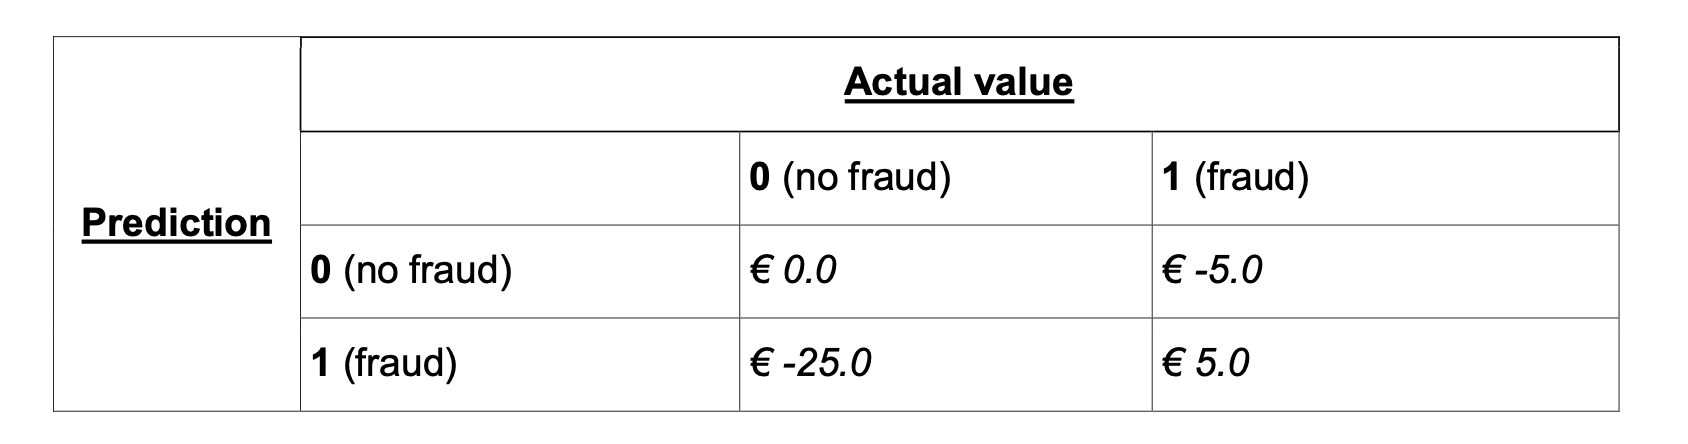

In [ ]:
def cost_function(Y_true, Y_preds):
    
    '''
    This a customized scoring function that takes two arguments:
    Y_true: true labels
    Y_preds: likelihoods from the model   
    '''
    
    ## Defining cutoff values in a data-frame
    results = pd.DataFrame({'cutoffs': np.round(np.linspace(0.05, 0.99, num = 50, endpoint = True), 2)})
    results['cost'] = np.nan
    
    for i in range(0, results.shape[0]):
        
        ## Changing likelihoods to labels
        Y_label = np.where(Y_preds < results.at[i, 'cutoffs'], 0, 1)
        
        ## Computing confusion matrix and scoring based on description
        X = confusion_matrix(Y_label, Y_true)
        results.at[i, 'cost'] = (0 * X[0, 0]) - (25 * X[1, 0]) - (5 * X[0, 1]) + (5 * X[1, 1])
        
    ## Sorting results 
    results = results.sort_values(by = 'cost', ascending = False).reset_index(drop = True)
    
    return results.at[0, 'cost']

## Defining the custom scorer
# my_scorer = make_scorer(cost_function, greater_is_better = True, needs_proba = True)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">XGBoost Modeling</h1>

In [ ]:
X = train[['totalScanTimeInSeconds', 'Heredity_Feature_1', 'Interaction_3', 'scannedLineItemsPerSecond', 'scansWithoutRegistration', 'valuePerSecond', 'lineItemVoids']]
Y = train['fraud']

## Defining list to store results
xgb_results = list()

for i in range(0, 5):
    
    kfold = StratifiedKFold(n_splits = 5, shuffle = True)
    
    ## Defining list to store fold results
    xgb_fold_result = list()
    
    for train_ix, test_ix in kfold.split(X, Y):
    
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        ## Building model
        xgb_md = XGBClassifier(n_estimators = 1000,
                               max_depth = 5,
                               min_child_weight = 5,
                               learning_rate = 0.01,
                               gamma = 0.01,
                               subsample = 0.8,
                               colsample_bytree = 0.8).fit(X_train, Y_train)
        
        ## Predicting on test
        xgb_pred = xgb_md.predict_proba(X_test)[:, 1]
        xgb_fold_result.append(cost_function(Y_test, xgb_pred))
    
    ## Appending average cost from k-fold run 
    xgb_results.append(np.mean(xgb_fold_result))
    
print('The average cost function over 5-fold CV (running 5 times) is', np.mean(xgb_results))

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">LightGBM Modeling</h1>

In [ ]:
X = train[['totalScanTimeInSeconds', 'grandTotal', 'Heredity_Feature_1', 'valuePerSecond', 'lineItemVoidsPerPosition', 'Heredity_Feature_3', 'scannedLineItemsPerSecond', 'scansWithoutRegistration']]
Y = train['fraud']

## Defining list to store results
lgb_results = list()

for i in range(0, 5):
    
    kfold = StratifiedKFold(n_splits = 5, shuffle = True)
    
    ## Defining list to store fold results
    lgb_fold_result = list()
    
    for train_ix, test_ix in kfold.split(X, Y):
    
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]

        ## Building model
        lgb_md = LGBMClassifier(n_estimators = 1000, 
                                learning_rate = 0.01,
                                num_leaves = 40,
                                max_depth = 15, 
                                lambda_l1 = 3, 
                                lambda_l2 = 1, 
                                bagging_fraction = 0.95, 
                                feature_fraction = 0.96).fit(X_train, Y_train)
        
        ## Predicting on test
        lgb_pred = lgb_md.predict_proba(X_test)[:, 1]
        lgb_fold_result.append(cost_function(Y_test, lgb_pred))
    
    ## Appending average cost from k-fold run 
    lgb_results.append(np.mean(lgb_fold_result))
    
print('The average cost function over 5-fold CV (running 5 times) is', np.mean(lgb_results))

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Next Steps</h1>

In terms of next steps, these are a couple of ideas:

1. A proper hyper-parameter optimization of the consider models.
2. Ensemble learning 